# Phase 4.5: Ablation Studies (Fixed Pipeline)

**Prerequisites:** Run `train_lora_adapters.ipynb` first to create real LoRA adapters and deltas.

## Key Improvements in This Version

1. **Fixed weight supervision** - Now uses direct MSE on LoRA weights (WeightLoss class)
2. **Pretrained text encoder** - Uses `all-MiniLM-L6-v2` instead of random embeddings
3. **Prompt batches** - Samples 8 prompts per adapter instead of just the first one

This notebook compares different training configurations:
1. **Multi-task** (λ_w=1.0, λ_d=0.1) - Both weight and delta supervision
2. **Multi-task balanced** (λ_w=0.5, λ_d=0.5) - Equal weight/delta supervision
3. **Delta-only** (λ_w=0.0, λ_d=1.0) - Behavioral supervision only
4. **Weight-only** (λ_w=1.0, λ_d=0.0) - Traditional DnD baseline (now actually works!)

Each configuration runs 3 trials with different seeds for statistical significance.

## Configuration

In [1]:
import sys
import os

# Colab setup
IN_COLAB = 'google.colab' in sys.modules
DRIVE_OUTPUT_DIR = None

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_OUTPUT_DIR = '/content/drive/MyDrive/llgbm/outputs'
    os.makedirs(DRIVE_OUTPUT_DIR, exist_ok=True)
    sys.path.insert(0, '/content/drive/MyDrive')
    CHECKPOINT_DIR = '/content/drive/MyDrive/llgbm/checkpoints'
    DELTAS_DIR = CHECKPOINT_DIR + '/deltas'
else:
    CHECKPOINT_DIR = './checkpoints'
    DELTAS_DIR = './llgbm/deltas'

Mounted at /content/drive


In [3]:
from llgbm import (
    AblationConfig,
    run_ablations,
    plot_ablation_results,
    # New components for fixed pipeline
    create_text_encoder,
    WeightLoss,
)

print("[OK] llgbm imports")
print("[INFO] Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2")
print("[INFO] Weight supervision now uses direct MSE on LoRA weights")

[OK] llgbm imports
[INFO] Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2
[INFO] Weight supervision now uses direct MSE on LoRA weights


In [ ]:
# Experiment configuration - modify these parameters as needed
config = AblationConfig(
    # Ablation configurations to compare
    configs={
        "multitask": {"lambda_weight": 1.0, "lambda_delta": 0.1},
        "multitask2": {"lambda_weight": 0.5, "lambda_delta": 0.5},
        "delta_only": {"lambda_weight": 0.0, "lambda_delta": 1.0},
        "weight_only": {"lambda_weight": 1.0, "lambda_delta": 0.0},
    },

    # Trial settings
    num_trials=3,
    seeds=[42, 123, 456],
    num_steps=100,

    # Paths
    checkpoint_dir=CHECKPOINT_DIR,
    deltas_dir=DELTAS_DIR,
    output_dir="outputs/phase4_5_ablations",

    # Model settings
    use_small_model=True,  # Qwen2.5-0.5B
    batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=25,

    # NEW: Text encoder settings
    text_encoder_name="sentence-transformers/all-MiniLM-L6-v2",
    freeze_text_encoder=True,
    num_prompts_per_adapter=8,  # Sample 8 prompts instead of just first one

    # Colab settings
    in_colab=IN_COLAB,
    drive_output_dir=DRIVE_OUTPUT_DIR,
)

print(f"Configurations: {list(config.configs.keys())}")
print(f"Total runs: {len(config.configs) * config.num_trials}")
print(f"Text encoder: {config.text_encoder_name}")
print(f"Prompts per adapter: {config.num_prompts_per_adapter}")

Configurations: ['multitask', 'multitask2', 'delta_only', 'weight_only']
Total runs: 12
Text encoder: sentence-transformers/all-MiniLM-L6-v2
Prompts per adapter: 8


## Run Ablations

In [ ]:
# Run all ablation experiments
results = run_ablations(config)

Configurations: ['multitask', 'multitask2', 'delta_only', 'weight_only']
Trials per config: 3
Steps per trial: 100
Total runs: 12
Model: Qwen/Qwen2.5-0.5B-Instruct
Device: cuda


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


[OK] Base model loaded
  Loaded 10 probes for arc_e
  Loaded 10 probes for boolq
  Loaded 10 probes for gsm8k
[OK] Probes: 30, FunctionalLoRA ready
[INFO] Loading text encoder: sentence-transformers/all-MiniLM-L6-v2
Text encoder: sentence-transformers/all-MiniLM-L6-v2
  Total params: 22,713,216
  Trainable: 0
  Embed dim: 384
[OK] Dataset: 30 samples, 8 prompts per adapter
[OK] WeightLoss criterion ready

Config: multitask | Trial 1 | Seed: 42
lambda_w=1.0, lambda_d=0.1
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0002, mean_cosine=0.0133, time=431.8s

Config: multitask | Trial 2 | Seed: 123
lambda_w=1.0, lambda_d=0.1
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0002, mean_cosine=0.0266, time=433.7s

Config: multitask | Trial 3 | Seed: 456
lambda_w=1.0, lambda_d=0.1
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0002, mean_cosine=0.0521, time=432.5s

Config: multitask2 | Trial 1 | Seed: 42
lambda_w=0.5, lambda_d=0.5
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0009, mean_cosine=0.0360, time=433.7s

Config: multitask2 | Trial 2 | Seed: 123
lambda_w=0.5, lambda_d=0.5
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0009, mean_cosine=0.0569, time=434.2s

Config: multitask2 | Trial 3 | Seed: 456
lambda_w=0.5, lambda_d=0.5
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0009, mean_cosine=0.0308, time=443.7s

Config: delta_only | Trial 1 | Seed: 42
lambda_w=0.0, lambda_d=1.0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0017, mean_cosine=0.0354, time=433.0s

Config: delta_only | Trial 2 | Seed: 123
lambda_w=0.0, lambda_d=1.0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0018, mean_cosine=0.0433, time=442.9s

Config: delta_only | Trial 3 | Seed: 456
lambda_w=0.0, lambda_d=1.0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0017, mean_cosine=0.0293, time=437.8s

Config: weight_only | Trial 1 | Seed: 42
lambda_w=1.0, lambda_d=0.0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0000, mean_cosine=0.0149, time=416.3s

Config: weight_only | Trial 2 | Seed: 123
lambda_w=1.0, lambda_d=0.0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0000, mean_cosine=-0.0095, time=416.5s

Config: weight_only | Trial 3 | Seed: 456
lambda_w=1.0, lambda_d=0.0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Training:   0%|          | 0/100 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/8 [00:00<?, ?it/s]

Result: loss=0.0000, mean_cosine=0.0002, time=417.3s


Completed 12 trials!

Saved to outputs/phase4_5_ablations/


## Results Summary

In [ ]:
import pandas as pd

df = results["dataframe"]

# Aggregate by config
agg_dict = {
    "final_loss": ["mean", "std"],
    "best_loss": ["mean", "std"],
    "train_time": ["mean"],
}
if "mean_cosine" in df.columns:
    agg_dict["mean_cosine"] = ["mean", "std"]

summary = df.groupby("config_name").agg(agg_dict).round(4)

print("\n" + "="*70)
print("ABLATION SUMMARY (mean +/- std over 3 trials)")
print("="*70)
print(summary.to_string())


ABLATION SUMMARY (mean +/- std over 3 trials)
            final_loss      best_loss      train_time mean_cosine        
                  mean  std      mean  std       mean        mean     std
config_name                                                              
delta_only      0.0017  0.0    0.0016  0.0   437.9039      0.0360  0.0070
multitask       0.0002  0.0    0.0002  0.0   432.6839      0.0306  0.0197
multitask2      0.0009  0.0    0.0009  0.0   437.2228      0.0412  0.0138
weight_only     0.0000  0.0    0.0000  0.0   416.7194      0.0019  0.0123


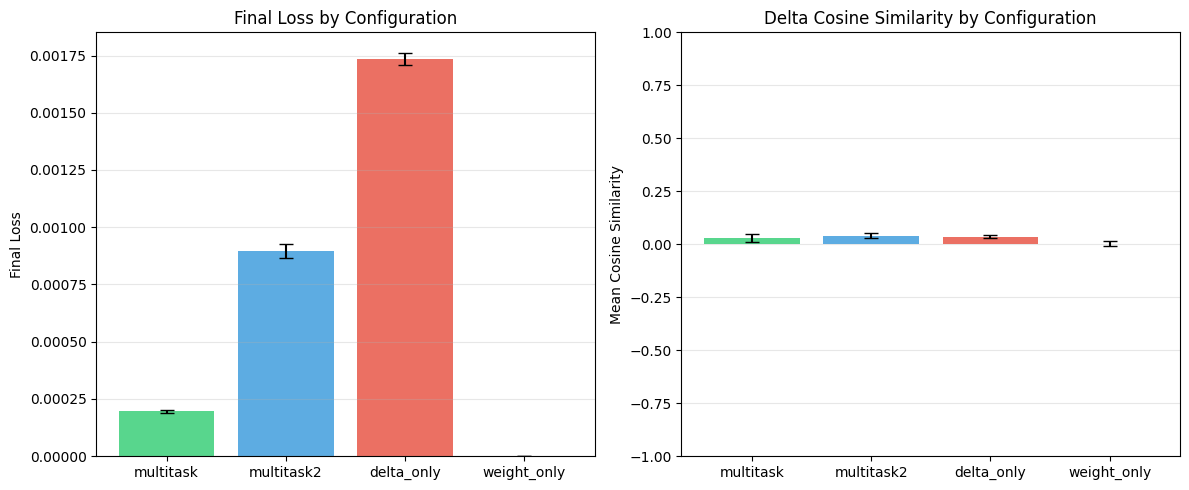

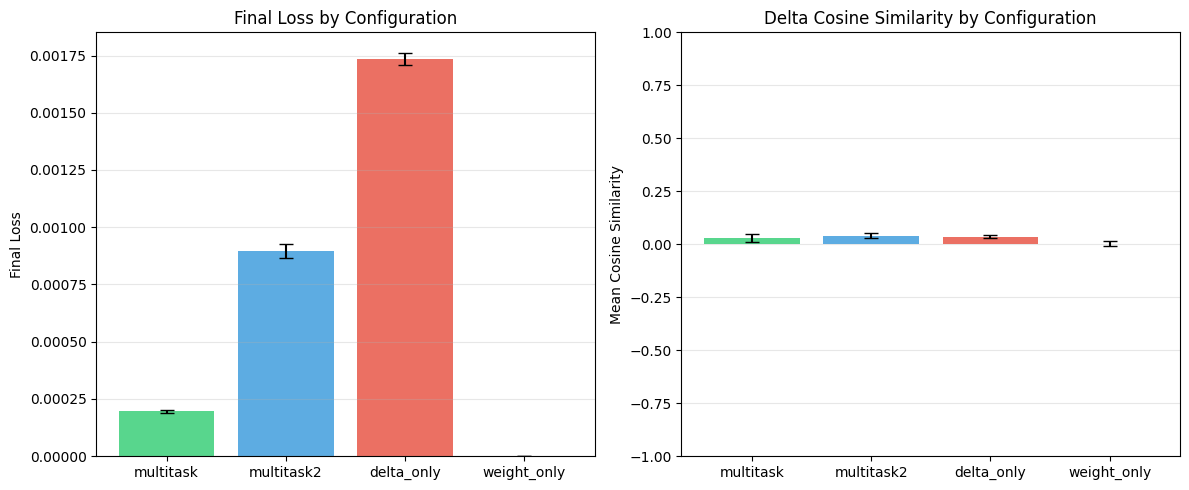

In [ ]:
# Visualization
from pathlib import Path
plot_ablation_results(df, Path(config.output_dir), list(config.configs.keys()))

In [ ]:
# Sync to Drive if in Colab
if IN_COLAB and DRIVE_OUTPUT_DIR:
    import shutil
    drive_dir = f"{DRIVE_OUTPUT_DIR}/phase4_5_ablations"
    if os.path.exists(drive_dir):
        shutil.rmtree(drive_dir)
    shutil.copytree(str(config.output_dir), drive_dir)
    print(f"[Drive] Synced to {drive_dir}")
else:
    print("[Local] Outputs saved to", config.output_dir)

[Drive] Synced to /content/drive/MyDrive/llgbm/outputs/phase4_5_ablations


In [ ]:
# Final summary
print("\n" + "="*70)
print("Phase 4.5 Ablations Complete!")
print("="*70)

print(f"\nKey findings (loss | cosine):")
for config_name in config.configs.keys():
    mean_loss = df[df['config_name']==config_name]['final_loss'].mean()
    std_loss = df[df['config_name']==config_name]['final_loss'].std()

    if 'mean_cosine' in df.columns:
        mean_cos = df[df['config_name']==config_name]['mean_cosine'].mean()
        std_cos = df[df['config_name']==config_name]['mean_cosine'].std()
        print(f"  {config_name:12s}: {mean_loss:.4f} +/- {std_loss:.4f} | {mean_cos:.4f} +/- {std_cos:.4f}")
    else:
        print(f"  {config_name:12s}: {mean_loss:.4f} +/- {std_loss:.4f}")

print(f"\nOutputs saved to: {config.output_dir}")


Phase 4.5 Ablations Complete!

Key findings (loss | cosine):
  multitask   : 0.0002 +/- 0.0000 | 0.0306 +/- 0.0197
  multitask2  : 0.0009 +/- 0.0000 | 0.0412 +/- 0.0138
  delta_only  : 0.0017 +/- 0.0000 | 0.0360 +/- 0.0070
  weight_only : 0.0000 +/- 0.0000 | 0.0019 +/- 0.0123

Outputs saved to: outputs/phase4_5_ablations


## Task Performance Evaluation (Optional)

Evaluate generated LoRAs using **eval loss** on held-out task data.

In [4]:
from llgbm import (
    compute_base_eval_loss,
    compute_accuracy_with_lora_batched,
    create_generator,
    load_checkpoint,
    TrainingConfig,
    FunctionalLoRA,
    RealAdapterDataset,
    create_text_encoder,
)
from transformers import AutoModelForCausalLM, AutoTokenizer
import json
import torch
from pathlib import Path

# Configuration
CONFIGS_TO_EVAL = ["delta_only", "multitask", "weight_only"]
NUM_TRIALS = 3
task_types = {"arc_e": "mcq", "boolq": "bool", "gsm8k": "gsm8k"}

# Load base model and tokenizer
base_config = TrainingConfig(use_small_model=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"[1] Loading base model: {base_config.base_model}")
base_model = AutoModelForCausalLM.from_pretrained(
    base_config.base_model,
    torch_dtype=torch.bfloat16,
    device_map=device,
    trust_remote_code=True,
)
base_model.eval()
tokenizer = AutoTokenizer.from_pretrained(base_config.base_model, trust_remote_code=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Create pretrained text encoder (same as training)
print("[2] Loading pretrained text encoder")
text_encoder = create_text_encoder(
    model_name="sentence-transformers/all-MiniLM-L6-v2",
    freeze=True,
    device=device,
)

# Load dataset with new settings
print("[3] Loading dataset with prompt batches")
dataset = RealAdapterDataset(
    CHECKPOINT_DIR,
    DELTAS_DIR,
    text_encoder.tokenizer,  # Use text encoder's tokenizer
    base_config,
    num_prompts=16,  # Sample 8 prompts per adapter
)
print(f"    {len(dataset)} samples, 16 prompts per adapter")

# Create FunctionalLoRA wrapper
functional_lora = FunctionalLoRA(
    base_model,
    lora_rank=base_config.lora_rank,
    lora_alpha=base_config.lora_alpha,
)

# Load eval data
print("[4] Loading eval data")
eval_splits_dir = Path('/content/drive/MyDrive/llgbm/data')
eval_data = {}
for task in ["arc_e", "boolq", "gsm8k"]:
    eval_file = eval_splits_dir / f"{task}_eval.json"
    if eval_file.exists():
        with open(eval_file) as f:
            eval_data[task] = json.load(f)
        print(f"    {task}: {len(eval_data[task])} samples")

# Evaluate base model first
print("\n" + "="*60)
print("BASE MODEL (no LoRA)")
print("="*60)
for task, samples in eval_data.items():
    loss = compute_base_eval_loss(base_model, samples, tokenizer)
    print(f"  {task}: loss={loss:.4f}")

# Collect all results
all_results = []

# Evaluate each config and trial
for config_name in CONFIGS_TO_EVAL:
    for trial in range(NUM_TRIALS):
        checkpoint_path = Path(f"/content/drive/MyDrive/llgbm/outputs/phase4_5_ablations/{config_name}_trial{trial}/checkpoint_best.pt")
        if not checkpoint_path.exists():
            continue

        print(f"\n" + "="*60)
        print(f"{config_name.upper()} TRIAL {trial}")
        print("="*60)

        # Load generator with pretrained text encoder
        generator = create_generator(
            base_config,
            seed=42,
            device=device,
            text_encoder=text_encoder,  # Use pretrained encoder
        )
        load_checkpoint(str(checkpoint_path), generator)
        generator.eval()

        trial_results = {"config": config_name, "trial": trial}

        for task, samples in eval_data.items():
            task_indices = [i for i, s in enumerate(dataset.samples) if s["task"] == task]
            if not task_indices:
                print(f"  {task}: [SKIP]")
                continue

            sample = dataset[task_indices[0]]

            # Handle new format with batched prompts
            if "condition_ids" in sample:
                condition_ids = sample["condition_ids"]  # (N, seq_len)
                attention_mask = sample["attention_mask"]  # (N, seq_len)
            else:
                # Using cached embeddings
                condition_ids = sample["condition_embedding"]
                attention_mask = None

            result = compute_accuracy_with_lora_batched(
                generator=generator,
                functional_lora=functional_lora,
                condition_ids=condition_ids,
                attention_mask=attention_mask,
                eval_samples=samples,
                tokenizer=tokenizer,
                task_type=task_types[task],
                max_samples=200,
                batch_size=12,
                device=device,
            )
            trial_results[task] = result["accuracy"]
            print(f"  {task}: {result['accuracy']:.2%} ({result['correct']}/{result['total']})")

        all_results.append(trial_results)
        del generator
        torch.cuda.empty_cache()

# Summary table
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
import pandas as pd
if all_results:
    df_eval = pd.DataFrame(all_results)
    summary = df_eval.groupby("config")[["arc_e", "boolq", "gsm8k"]].agg(["mean", "std"])
    print(summary.round(4).to_string())

[1] Loading base model: Qwen/Qwen2.5-0.5B-Instruct


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/988M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

[2] Loading pretrained text encoder


config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Text encoder: sentence-transformers/all-MiniLM-L6-v2
  Total params: 22,713,216
  Trainable: 0
  Embed dim: 384
[3] Loading dataset with prompt batches
    30 samples, 16 prompts per adapter
[4] Loading eval data
    arc_e: 2376 samples
    boolq: 3270 samples
    gsm8k: 1319 samples

BASE MODEL (no LoRA)
  arc_e: loss=4.5127
  boolq: loss=5.9186
  gsm8k: loss=1.7362

DELTA_ONLY TRIAL 0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:29<00:00,  1.71s/it, acc=56.00%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 56.00% (112/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.63it/s, acc=63.00%]


  boolq: 63.00% (126/200)


Evaluating batches: 100%|██████████| 17/17 [01:19<00:00,  4.69s/it, acc=2.00%]


  [INFO] Parse failures: 10/200 (5.0%)
  gsm8k: 2.00% (4/200)

DELTA_ONLY TRIAL 1
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:24<00:00,  1.42s/it, acc=55.50%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 55.50% (111/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.64it/s, acc=63.00%]


  boolq: 63.00% (126/200)


Evaluating batches: 100%|██████████| 17/17 [01:21<00:00,  4.78s/it, acc=1.50%]


  [INFO] Parse failures: 11/200 (5.5%)
  gsm8k: 1.50% (3/200)

DELTA_ONLY TRIAL 2
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:30<00:00,  1.79s/it, acc=56.00%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 56.00% (112/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.60it/s, acc=63.00%]


  boolq: 63.00% (126/200)


Evaluating batches: 100%|██████████| 17/17 [01:22<00:00,  4.83s/it, acc=3.50%]


  [INFO] Parse failures: 10/200 (5.0%)
  gsm8k: 3.50% (7/200)

MULTITASK TRIAL 0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:24<00:00,  1.44s/it, acc=55.50%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 55.50% (111/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.21it/s, acc=63.50%]


  boolq: 63.50% (127/200)


Evaluating batches: 100%|██████████| 17/17 [01:23<00:00,  4.91s/it, acc=1.50%]


  [INFO] Parse failures: 8/200 (4.0%)
  gsm8k: 1.50% (3/200)

MULTITASK TRIAL 1
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:24<00:00,  1.46s/it, acc=56.00%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 56.00% (112/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.02it/s, acc=63.00%]


  boolq: 63.00% (126/200)


Evaluating batches: 100%|██████████| 17/17 [01:23<00:00,  4.90s/it, acc=1.50%]


  [INFO] Parse failures: 13/200 (6.5%)
  gsm8k: 1.50% (3/200)

MULTITASK TRIAL 2
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:30<00:00,  1.80s/it, acc=55.50%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 55.50% (111/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.34it/s, acc=63.50%]


  boolq: 63.50% (127/200)


Evaluating batches: 100%|██████████| 17/17 [01:22<00:00,  4.85s/it, acc=2.00%]


  [INFO] Parse failures: 9/200 (4.5%)
  gsm8k: 2.00% (4/200)

WEIGHT_ONLY TRIAL 0
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:24<00:00,  1.44s/it, acc=55.00%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 55.00% (110/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.35it/s, acc=63.00%]


  boolq: 63.00% (126/200)


Evaluating batches: 100%|██████████| 17/17 [01:21<00:00,  4.82s/it, acc=3.00%]


  [INFO] Parse failures: 12/200 (6.0%)
  gsm8k: 3.00% (6/200)

WEIGHT_ONLY TRIAL 1
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:24<00:00,  1.43s/it, acc=56.50%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 56.50% (113/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.38it/s, acc=63.00%]


  boolq: 63.00% (126/200)


Evaluating batches: 100%|██████████| 17/17 [01:21<00:00,  4.81s/it, acc=2.50%]


  [INFO] Parse failures: 11/200 (5.5%)
  gsm8k: 2.50% (5/200)

WEIGHT_ONLY TRIAL 2
  Generator params: 33,642,320
  Using pretrained text encoder: sentence-transformers/all-MiniLM-L6-v2


Evaluating batches: 100%|██████████| 17/17 [00:30<00:00,  1.77s/it, acc=56.50%]


  [INFO] Parse failures: 8/200 (4.0%)
  arc_e: 56.50% (113/200)


Evaluating batches: 100%|██████████| 17/17 [00:02<00:00,  7.47it/s, acc=63.50%]


  boolq: 63.50% (127/200)


Evaluating batches: 100%|██████████| 17/17 [01:21<00:00,  4.81s/it, acc=2.50%]

  [INFO] Parse failures: 10/200 (5.0%)
  gsm8k: 2.50% (5/200)

SUMMARY
              arc_e           boolq           gsm8k        
               mean     std    mean     std    mean     std
config                                                     
delta_only   0.5583  0.0029  0.6300  0.0000  0.0233  0.0104
multitask    0.5567  0.0029  0.6333  0.0029  0.0167  0.0029
weight_only  0.5600  0.0087  0.6317  0.0029  0.0267  0.0029
